# Import Object

In [23]:
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn import preprocessing

from models import Seq2Seq, Encoder, Decoder
from train_model import train_seq2seq_net

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [25]:
train_x = pd.read_csv("./data/X_train.csv").values
train_y = pd.read_csv("./data/Y_train.csv").values.reshape(-1)

ss = preprocessing.StandardScaler()
train_x = ss.fit_transform(train_x)

num_days = int(train_x.shape[0] / 16)
train_x = train_x.reshape(num_days, 16, 16)
train_y = train_y.reshape(num_days, 16, 1)
train_x, test_x, train_y, test_y = train_test_split(train_x,
                                                    train_y,
                                                    test_size=0.35,
                                                    shuffle=True)

train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

train_ds = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Set Free Parameters

In [26]:
input_size_encoder = 16
input_size_decoder = 1
num_layers = 1
hidden_size = 50
num_classes = 2
learning_rate = 0.001
num_epochs = 50
dropout_ratio = 0.5

# Instantiate Model, Criterion, Optimizer

In [27]:
encoder_net = Encoder(input_size_encoder, hidden_size,
                      num_layers, dropout_ratio).to(device)
decoder_net = Decoder(input_size_decoder, hidden_size,
                      num_classes, num_layers, dropout_ratio).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/higuchi-lab/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Training

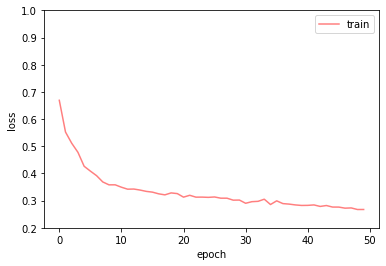

In [28]:
model = train_seq2seq_net(model, criterion, optimizer,
                          num_epochs, train_loader, device)

# Accuracy

In [30]:
decoder_y = test_y[:, :-1, :]

decoder_t = test_y[:, 1:, :]
decoder_t = decoder_t.reshape(-1)

pred_y, _ = model.generate(test_x, decoder_y, decoder_y.shape[1], device)
pred_y = pred_y.reshape(-1)

print(sum(pred_y == decoder_t) / int(decoder_t.shape[0]))

tensor(0.8028, device='cuda:0')
